<a href="https://colab.research.google.com/github/hyunjaec/MScA_Machine_Learning_Project/blob/main/medical_deepfakes_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import pydicom
import scipy.ndimage

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = np.float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [7]:
#! ls 'drive/My Drive/data_ml'
path = '/Users/milantoolsidas/Documents/UChicago/Spring_2022/MScA_31009_Machine_Learning/Project/'
! ls /Users/milantoolsidas/Documents/UChicago/Spring_2022/MScA_31009_Machine_Learning/Project/ 

MScA_Machine_Learning_Project Untitled.ipynb
Project_EDA.ipynb             data_ml


In [8]:
os.listdir(path + 'data_ml/Experiment 2 - Open')

['2220',
 '2592',
 '2575',
 '1563',
 '6031',
 '1876',
 '3341',
 '2031',
 '7507',
 '1251',
 '2960',
 '2703',
 '2199',
 '4635',
 '2590',
 '2366',
 '1796',
 '4709',
 '2495',
 '1610']

In [71]:
from tqdm import tqdm 

scan_uuids = os.listdir(path + 'data_ml/Experiment 2 - Open')

scan = []
spacing = []
orientation = []
origin = []
raw_slices = []
for id in tqdm(scan_uuids):
  sc, sp, ori, org, rs = load_dicom(path + '/data_ml/Experiment 2 - Open/'+id)
  scan.append(sc)
  spacing.append(sp)
  orientation.append(ori)
  origin.append(org)
  raw_slices += rs

print('The CT scan has the dimensions of',scan[0].shape,'  (z,y,x)')

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-2-6217c5542aed>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spacing_z = np.float(first_slice_data.SliceThickness)
100%|██████████| 20/20 [00:43<00:00,  2.17s/it]

The CT scan has the dimensions of (481, 512, 512)   (z,y,x)


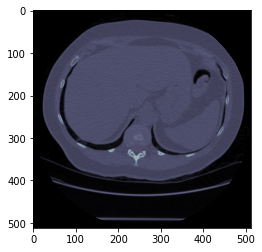

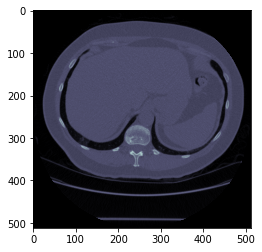

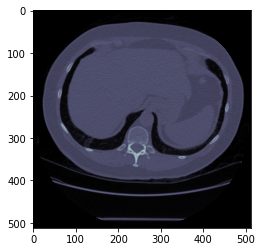

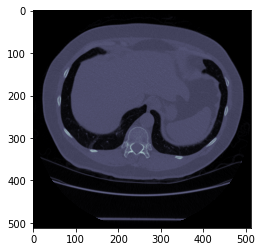

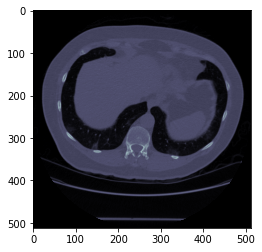

In [73]:
from matplotlib import pyplot as plt

for slice_indx in range(50,100,10):
    plt.imshow(scan[0][slice_indx,:,:],cmap='bone',vmin=-1000,vmax=2000)
    plt.show()

In [74]:
df = pd.read_csv(path + 'data_ml/labels_exp2.csv')
locations = df.loc[df['uuid'].isin([int(i) for i in scan_uuids])]
locations

,type,uuid,slice,x,y
0,FB,1251,150,418,350
1,FB,1251,188,402,294
2,FB,1251,272,163,298
3,FB,2592,163,230,322
4,FB,1876,146,414,181
5,FB,7507,319,125,323
6,FB,7507,201,316,362
7,FB,6031,64,240,290
8,FB,6031,65,365,395
9,FB,6031,51,119,315


In [75]:
def cutCube(X, center, shape, padd=0): #center is a 3d coord (zyx)
    center = center.astype(int)
    hlz = np.round(shape[0] / 2)
    hly = np.round(shape[1] / 2)
    hlx = np.round(shape[2] / 2)

    #add padding if out of bounds
    if ((center - np.array([hlz,hly,hlx])) < 0).any() or (
        (center + np.array([hlz,hly,hlx]) + 1) > np.array(X.shape)).any():  # if cropping is out of bounds, add padding
        try:
          np.ones(np.array(X.shape) + shape * 2)
        except:
          return "No"
        Xn = np.ones(np.array(X.shape) + shape * 2) * padd
        Xn[shape[0]:(shape[0] + X.shape[0]), shape[1]:(shape[1] + X.shape[1]), shape[2]:(shape[2] + X.shape[2])] = X
        centern = center + shape
        cube = Xn[int(centern[0] - hlz):int(centern[0] - hlz + shape[0]),
               int(centern[1] - hly):int(centern[1] - hly + shape[1]),
               int(centern[2] - hlx):int(centern[2] - hlx + shape[2])]
        return np.copy(cube)
    else:
        cube = X[int(center[0] - hlz):int(center[0] - hlz + shape[0]), int(center[1] - hly):int(center[1] - hly + shape[1]),
               int(center[2] - hlx):int(center[2] - hlx + shape[2])]
        return np.copy(cube)


In [77]:
cut_cubes = []
for i in tqdm(range(len(locations))):
    for s in scan:
        location = locations.iloc[i]
        coord = np.array([location['slice'],location['y'],location['x']])
        cut_cubes.append(cutCube(s,coord,(64,64,64)))

#disply the slices of each cut cube:
# for cube in cut_cubes:
#     plt.figure(num=None, figsize=(10, 10), dpi=200)
#     for i in range(64):
#         plt.subplot(8,8,i+1)
#         plt.axis('off')
#         plt.tight_layout()
#         try:
#           plt.imshow(cube[i,:,:],cmap='bone')
#         except:
#           print(i)
#     plt.show()

100%|██████████| 36/36 [00:05<00:00,  6.04it/s]


In [78]:
import os
dir = path + 'data_ml/Experiment 2 - Open/'
r=[]
for root, dirs, files in os.walk(dir):
  r.append(root)

In [79]:
label_df1 = pd.read_csv(path + 'data_ml/Response EXP2 - Reviewer 1_instances.csv')
label_df2 = pd.read_csv(path + 'data_ml/Response EXP2 - Reviewer 2_instances.csv')
label_df3 = pd.read_csv(path + 'data_ml/Response EXP2 - Reviewer 3_instances.csv')

preds = pd.concat([label_df1[['label','prediction','confidence']], label_df2[['label','prediction','confidence']], label_df3[['label','prediction','confidence']]], axis = 1)
preds.columns = ['label1','prediction1','confidence1','label2','prediction2','confidence2','label3','prediction3','confidence3']

def final_label(row):
  row.label1 = int(row.label1)
  row.label2 = int(row.label2)
  row.label3 = int(row.label3)
  if row.label1 == 0:
        row.label1 == -1
  if row.label2 == 0:
        row.label2 == -1
  if row.label3 == 0:
        row.label3 == -1
  if row.label1 == row.label2 == row.label3:
    return bool(row.label1)
  else:
    return bool(np.sign((row.label1*row.confidence1 + row.label1*row.confidence2 + row.label1*row.confidence3) / 3))

preds['label'] = preds.apply(lambda row: final_label(row), axis = 1)
label_df = pd.concat([label_df1.drop('label', axis = 1), preds['label']], axis = 1)
label_df

,type,uuid,slice,x,y,detected,detected_diam,prediction,confidence,label
0,FB,1251,150,418,350,False,0.0,TB,5.0,True
1,FB,1251,188,402,294,False,0.0,TB,5.0,True
2,FB,1251,272,163,298,False,0.0,TB,5.0,True
3,FB,2592,163,230,322,False,0.0,TB,5.0,True
4,FB,1876,146,414,181,False,0.0,TB,5.0,True
5,FB,7507,319,125,323,False,0.0,TB,5.0,True
6,FB,7507,201,316,362,False,0.0,TB,5.0,True
7,FB,6031,64,240,290,False,0.0,TB,5.0,True
8,FB,6031,65,365,395,False,0.0,TB,5.0,True
9,FB,6031,51,119,315,False,0.0,TB,5.0,True


In [80]:
df_true = label_df.loc[label_df['label']==True]
df_false = label_df.loc[label_df['label']==False]
len(label_df)

36

In [81]:
df_true.uuid[0]

1251

In [83]:
df_true = df_true.reset_index()
df_false = df_false.reset_index()

In [84]:
from tqdm import tqdm

def image_cut_processing(df):
  cut_cubes = []
  for i in tqdm(range(0,len(df))):
    scan, spacing, orientation, origin, raw_slices = load_dicom(path + 'data_ml/Experiment 2 - Open/'+str(df.uuid[i]))
    uuid_row = df.loc[df['uuid'] == df.uuid[i]]
    for j in range(len(uuid_row)):
      location = uuid_row.iloc[j]
      coord = np.array([location['slice'],location['y'],location['x']])
      if (cutCube(scan,coord,(64,64,64))) != "No":
        cut_cubes.append(cutCube(scan,coord,(64,64,64)))
  return cut_cubes
  

In [85]:
true_cut_images = image_cut_processing(df_true)

  0%|          | 0/23 [00:00<?, ?it/s]<ipython-input-2-6217c5542aed>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spacing_z = np.float(first_slice_data.SliceThickness)
<ipython-input-84-71d2a034695d>:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (cutCube(scan,coord,(64,64,64))) != "No":
100%|██████████| 23/23 [01:06<00:00,  2.89s/it]


In [86]:
false_cut_images = image_cut_processing(df_false)

  0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-2-6217c5542aed>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spacing_z = np.float(first_slice_data.SliceThickness)
<ipython-input-84-71d2a034695d>:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (cutCube(scan,coord,(64,64,64))) != "No":
100%|██████████| 13/13 [00:16<00:00,  1.27s/it]


In [87]:
list1 = [True for i in range(len(true_cut_images))]
list2 = [False for i in range(len(false_cut_images))]
y = list1+list2
y = np.array(y)

In [88]:
y = pd.get_dummies(y)

In [89]:
X = true_cut_images + false_cut_images

In [90]:
len(X), len(y)

(63, 63)

In [91]:
y['label'] = (y[True] == 1).astype(int)

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y['label'], test_size=.2)

In [124]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [125]:
len(y_train), len(y_test)

(50, 13)

In [126]:
y.label.to_numpy()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [127]:
X_test[8].shape, y_train[8].shape

((64, 64, 64), ())

In [128]:
X_train.shape

(50, 64, 64, 64)

In [129]:
nsamples, nx, ny, nz = X_train.shape
X_train_flattened = X_train.reshape((nsamples,nx*ny*nz))
X_test_flattened = X_test.reshape((X_test.shape[0],nx*ny*nz))

In [130]:
X_train_flattened.shape

(50, 262144)

In [131]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_flattened, y_train)

SVC()

In [132]:
from sklearn.metrics import confusion_matrix, classification_report

preds = svc.predict(X_test_flattened)

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 0  1]
 [ 0 12]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      1.00      0.96        12

    accuracy                           0.92        13
   macro avg       0.46      0.50      0.48        13
weighted avg       0.85      0.92      0.89        13



/Users/milantoolsidas/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/milantoolsidas/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/milantoolsidas/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r